In [1]:
import numpy as np
import numpy_html
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [2]:
np.set_printoptions(precision=3)

In [3]:
#define the shape of the environment (i.e., its states)
environment_rows = 14
environment_columns = 15

#Create a 3D numpy array to hold the current Q-values for each state and action pair: Q(s, a) 
#The array contains 11 rows and 11 columns (to match the shape of the environment), as well as a third "action" dimension.
#The "action" dimension consists of 4 layers that will allow us to keep track of the Q-values for each possible action in
#each state (see next cell for a description of possible actions). 
#The value of each (state, action) pair is initialized to 0.
#q_values = np.zeros((environment_rows, environment_columns, 4))

#### Actions
The actions that are available to the AI agent are to move the robot in one of four directions:
* Up
* Right
* Down
* Left

Obviously, the AI agent must learn to avoid driving into the item storage locations (e.g., shelves)!


In [4]:
#define actions
#numeric action codes: 0 = up, 1 = right, 2 = down, 3 = left
actions = ['up', 'right', 'down', 'left']

#### Rewards
The last component of the environment that we need to define are the **rewards**. 

To help the AI agent learn, each state (location) in the warehouse is assigned a reward value.

The agent may begin at any white square, but its goal is always the same: ***to maximize its total rewards***!

Negative rewards (i.e., **punishments**) are used for all states except the goal.
* This encourages the AI to identify the *shortest path* to the goal by *minimizing its punishments*!

![warehouse map](https://www.danielsoper.com/teaching/img/08-warehouse-map-rewards.png)

To maximize its cumulative rewards (by minimizing its cumulative punishments), the AI agent will need find the shortest paths between the item packaging area (green square) and all of the other locations in the warehouse where the robot is allowed to travel (white squares). The agent will also need to learn to avoid crashing into any of the item storage locations (black squares)!

In [5]:
#Create a 2D numpy array to hold the rewards for each state. 
#The array contains 11 rows and 11 columns (to match the shape of the environment), and each value is initialized to -100.
rewards = np.full((environment_rows, environment_columns), -1)
rewards[11, 5] = 1. #set the reward for the packaging area (i.e., the goal) to 100

#define aisle locations (i.e., white squares) for rows 1 through 9
aisles = {} #store locations in a dictionary
aisles[0] = [i for i in range(0, 15)]
aisles[1] = [0,1] + [i for i in range(5, 15)]
aisles[2] = [13,14] + [i for i in range(0, 9)]
aisles[3] = [i for i in range(15)]
aisles[4] = [0] + [i for i in range(9, 15)]
aisles[5] = [i for i in range(15)]
aisles[6] = [i for i in range(1,10)] + [11,12,14]
aisles[7] = [i for i in range(1,10)] + [11,12,13,14]
aisles[8] = [i for i in range(0,10)] + [11,12,13,14]
aisles[9] = [i for i in range(0,10)] + [11,12,14]
aisles[10] = [i for i in range(7,10)] + [0,11,12,14]
aisles[11] = [i for i in range(0,10)] + [10,11,12,14]
aisles[12] = [i for i in range(0,10)] + [10,11,12,14]
aisles[13] = [i for i in range(0,10)] + [10,11,12,14]

#set the rewards for all aisle locations (i.e., white squares)
for row_index in range(0, 14):
    for column_index in aisles[row_index]:
        rewards[row_index, column_index] = float(0)
rewards[11, 5] = 1.
  
#print rewards matrix
for row in rewards:
    print(row)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1 -1 -1 -1  0  0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0 -1 -1 -1 -1 -1 -1 -1 -1  0  0  0  0  0  0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[-1  0  0  0  0  0  0  0  0  0 -1  0  0 -1  0]
[-1  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  0 -1  0]
[ 0 -1 -1 -1 -1 -1 -1  0  0  0 -1  0  0 -1  0]
[ 0  0  0  0  0  1  0  0  0  0  0  0  0 -1  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]


## Train the Model
Our next task is for our AI agent to learn about its environment by implementing a Q-learning model. The learning process will follow these steps:
1. Choose a random, non-terminal state (white square) for the agent to begin this new episode.
2. Choose an action (move *up*, *right*, *down*, or *left*) for the current state. Actions will be chosen using an *epsilon greedy algorithm*. This algorithm will usually choose the most promising action for the AI agent, but it will occasionally choose a less promising option in order to encourage the agent to explore the environment.
3. Perform the chosen action, and transition to the next state (i.e., move to the next location).
4. Receive the reward for moving to the new state, and calculate the temporal difference.
5. Update the Q-value for the previous state and action pair.
6. If the new (current) state is a terminal state, go to #1. Else, go to #2.

This entire process will be repeated across 1000 episodes. This will provide the AI agent sufficient opportunity to learn the shortest paths between the item packaging area and all other locations in the warehouse where the robot is allowed to travel, while simultaneously avoiding crashing into any of the item storage locations!

#### Define Helper Functions

In [6]:
def get_next_action(current_row,current_column,eps,q):
    y = current_row
    x = current_column
    if np.random.rand()<eps:
        action_index_candidates = np.argwhere(q[y, x] == np.max(q[y, x]))
        chosen_action_index = np.random.choice(action_index_candidates.flatten(), size=1)[0]
        return chosen_action_index
    else:
        return (np.random.randint(4))

In [7]:
#define a function that determines if the specified location is a terminal state
def is_terminal_state(current_row_index, current_column_index):
  #if the reward for this location is -1, then it is not a terminal state (i.e., it is a 'white square')
    if rewards[current_row_index, current_column_index] == 1:
        return True
    else:
        return False

def is_invalid_state(current_row_index, current_column_index):
  #if the reward for this location is -1, then it is not a terminal state (i.e., it is a 'white square')
    if rewards[current_row_index, current_column_index] == -1:
        return True
    else:
        return False

#define a function that will choose a random, non-terminal starting location
def get_starting_location():
    #get a random row and column index
    current_row_index = 0
    current_column_index = 0
    #continue choosing random row and column indexes until a non-terminal state is identified
    #(i.e., until the chosen state is a 'white square').
    while is_terminal_state(current_row_index, current_column_index):
        current_row_index = 0
        current_column_index = 0
    return current_row_index, current_column_index


        #tempmax = -10
        #choices = [0,1,2,3]
        #options=[]
        #for choice in choices:
        #    if(q_values[current_row_index,current_column_index,choice]>=tempmax):
        #        tempmax=q_values[current_row_index,current_column_index,choice]
        #        options.append(choice)
        #chosen_action_index = random.choice(options)


#define a function that will get the next location based on the chosen action
def get_next_location(current_row_index, current_column_index, action_index):
    new_row_index = current_row_index
    new_column_index = current_column_index
    hit_boundary=True
    if actions[action_index] == 'up' and current_row_index > 0:
        new_row_index -= 1
        hit_boundary=False
    elif actions[action_index] == 'right' and current_column_index < environment_columns - 1:
        new_column_index += 1
        hit_boundary=False
    elif actions[action_index] == 'down' and current_row_index < environment_rows - 1:
        new_row_index += 1
        hit_boundary=False
    elif actions[action_index] == 'left' and current_column_index > 0:
        new_column_index -= 1
        hit_boundary=False
    return new_row_index, new_column_index,hit_boundary

#Define a function that will get the shortest path between any location within the warehouse that 
#the robot is allowed to travel and the item packaging location.
def get_shortest_path(start_row_index, start_column_index,q):
    q=q
    #return immediately if this is an invalid starting location
    if is_terminal_state(start_row_index, start_column_index):
        return []
    else: #if this is a 'legal' starting location
        current_row_index, current_column_index = start_row_index, start_column_index
        shortest_path = []
        shortest_path.append([current_row_index, current_column_index])
    #continue moving along the path until we reach the goal (i.e., the item packaging location)
    while not is_terminal_state(current_row_index, current_column_index):
        #get the best action to take
        action_index = get_next_action(current_row_index, current_column_index, 1,q)
        #print("Location:",current_row_index,current_column_index," and values are :",q[current_row_index,current_column_index])
        #move to the next location on the path, and add the new location to the list
        y_new, x_new,hit_boundary = get_next_location(current_row_index, current_column_index, action_index)
        if(is_invalid_state(y_new,x_new)):
            current_row_index=current_row_index
            current_column_index=current_column_index
        else:
            current_row_index = y_new
            current_column_index = x_new 
        shortest_path.append([current_row_index, current_column_index])
    return shortest_path

#### Train the AI Agent using Q-Learning

In [8]:
# RUN 1
#define training parameters
q_values1 = np.zeros((environment_rows, environment_columns, 4))
epsilon = (1-0.1) #the percentage of time when we should take the best action (instead of a random action)
gamma = 0.95 #discount factor for future rewards
learning_rate = 0.1 #the rate at which the AI agent should learn
i = 0
state_sum1=[]
#run through 1000 training episodes
for episode in tqdm(range(10000)):
    state = 0
   # print("training episode ",episode,"/10000"  )
  #get the starting location for this episode
    y, x = get_starting_location()
    #print("got starting loc")
  #continue taking actions (i.e., moving) until we reach a terminal state
  #(i.e., until we reach the item packaging area or crash into an item storage location)
    while (not is_terminal_state(y, x)):
        #choose which action to take (i.e., where to move next)
        a = get_next_action(y, x, epsilon,q_values1)
        state = state+1
        #if state>2200:
        #    break
        y_new, x_new,hit_boundary = get_next_location(y, x, a)
        if is_invalid_state(y_new,x_new):
            y_new = y
            x_new = x
        r = rewards[y, x]
        if r == -1:
            r=0
            print("hit wall",y,x,"moved ",actions[a])
        if hit_boundary:
            r=0
        if(y_new == 11 and x_new==5):
            r=1
        q_values1[y, x, a] += learning_rate * (r + gamma * np.max(q_values1[y_new, x_new]) - q_values1[y, x, a])
        x, y = x_new, y_new
        #if(y_new == 11 and x_new==5):
            
            #break
    state_sum1.append(state)
    #print("arrived, reward is: ",rewards[y,x])
        

print('Training complete!')

100%|██████████| 10000/10000 [00:21<00:00, 465.24it/s]

Training complete!


In [48]:
rewards = np.full((environment_rows, environment_columns), -1,dtype= float) #wall value

rewards[11, 5] = 1 #set the reward for the packaging area (i.e., the goal) to 100

#define aisle locations (i.e., white squares) for rows 1 through 9
aisles = {} #store locations in a dictionary
aisles[0] = [i for i in range(0, 15)]
aisles[1] = [0,1] + [i for i in range(5, 15)]
aisles[2] = [13,14] + [i for i in range(0, 9)]
aisles[3] = [i for i in range(15)]
aisles[4] = [0] + [i for i in range(9, 15)]
aisles[5] = [i for i in range(15)]
aisles[6] = [i for i in range(1,10)] + [11,12,14]
aisles[7] = [i for i in range(1,10)] + [11,12,13,14]
aisles[8] = [i for i in range(0,10)] + [11,12,13,14]
aisles[9] = [i for i in range(0,10)] + [11,12,14]
aisles[10] = [i for i in range(7,10)] + [0,11,12,14]
aisles[11] = [i for i in range(0,10)] + [10,11,12,14]
aisles[12] = [i for i in range(0,10)] + [10,11,12,14]
aisles[13] = [i for i in range(0,10)] + [10,11,12,14]

#set the rewards for all aisle locations (i.e., white squares)
for row_index in range(0, 14):
    for column_index in aisles[row_index]:
        rewards[row_index, column_index] = -0.05
rewards[11, 5] = 1
  
#print rewards matrix
for row in rewards:
    print(row)

[-0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05
 -0.05 -0.05 -0.05]
[-0.05 -0.05 -1.   -1.   -1.   -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05
 -0.05 -0.05 -0.05]
[-0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -1.   -1.   -1.
 -1.   -0.05 -0.05]
[-0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05
 -0.05 -0.05 -0.05]
[-0.05 -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -0.05 -0.05 -0.05
 -0.05 -0.05 -0.05]
[-0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05
 -0.05 -0.05 -0.05]
[-1.   -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -1.   -0.05
 -0.05 -1.   -0.05]
[-1.   -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -1.   -0.05
 -0.05 -0.05 -0.05]
[-0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -1.   -0.05
 -0.05 -0.05 -0.05]
[-0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -1.   -0.05
 -0.05 -1.   -0.05]
[-0.05 -1.   -1.   -1.   -1.   -1.   -1.   -0.05 -0.05 -0.05 -1.   -0.05

In [49]:
# RUN 2
q_values2 = np.zeros((environment_rows, environment_columns, 4))
epsilon = 1-0.1 #the percentage of time when we should take the best action (instead of a random action)
gamma = 0.95 #discount factor for future rewards
learning_rate = 0.1 #the rate at which the AI agent should learn
i = 0
state_sum2=[]
#run through 1000 training episodes
for episode in tqdm(range(10000)):
    state=0
   # print("training episode ",episode,"/10000"  )
  #get the starting location for this episode
    y, x = get_starting_location()
    #print("got starting loc")
  #continue taking actions (i.e., moving) until we reach a terminal state
  #(i.e., until we reach the item packaging area or crash into an item storage location)
    while (not is_terminal_state(y, x)):
        #choose which action to take (i.e., where to move next)
        a = get_next_action(y, x, epsilon,q_values2)
        state = state+1
        y_new, x_new,hit_boundary= get_next_location(y, x, a)
        if is_invalid_state(y_new,x_new):
            y_new = y
            x_new = x
        r = rewards[y, x]
        if r == -1:
            r=0
            print("hit wall",y,x,"moved ",actions[a])
        if(y_new == 11 and x_new==5):
            r=1
        q_values2[y, x, a] += learning_rate * (r + gamma * np.max(q_values2[y_new, x_new]) - q_values2[y, x, a])
        x, y = x_new, y_new
        #if(y_new == 11 and x_new==5):
            #print("arrived, reward is: ",rewards[y_new,x_new])
            #break
    state_sum2.append(state)
        

print('Training complete!')

100%|██████████| 10000/10000 [00:18<00:00, 555.11it/s]

Training complete!


In [11]:
rewards = np.full((environment_rows, environment_columns), -1,dtype= float)
rewards[11, 5] = 1. #set the reward for the packaging area (i.e., the goal) to 100

#define aisle locations (i.e., white squares) for rows 1 through 9
aisles = {} #store locations in a dictionary
aisles[0] = [i for i in range(0, 15)]
aisles[1] = [0,1] + [i for i in range(5, 15)]
aisles[2] = [13,14] + [i for i in range(0, 9)]
aisles[3] = [i for i in range(15)]
aisles[4] = [0] + [i for i in range(9, 15)]
aisles[5] = [i for i in range(15)]
aisles[6] = [i for i in range(1,10)] + [11,12,14]
aisles[7] = [i for i in range(1,10)] + [11,12,13,14]
aisles[8] = [i for i in range(0,10)] + [11,12,13,14]
aisles[9] = [i for i in range(0,10)] + [11,12,14]
aisles[10] = [i for i in range(7,10)] + [0,11,12,14]
aisles[11] = [i for i in range(0,10)] + [10,11,12,14]
aisles[12] = [i for i in range(0,10)] + [10,11,12,14]
aisles[13] = [i for i in range(0,10)] + [10,11,12,14]

#set the rewards for all aisle locations (i.e., white squares)
for row_index in range(0, 14):
    for column_index in aisles[row_index]:
        rewards[row_index, column_index] = -0.05
rewards[11, 5] = 1.
  
#print rewards matrix
for row in rewards:
    print(row)

[-0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05
 -0.05 -0.05 -0.05]
[-0.05 -0.05 -1.   -1.   -1.   -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05
 -0.05 -0.05 -0.05]
[-0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -1.   -1.   -1.
 -1.   -0.05 -0.05]
[-0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05
 -0.05 -0.05 -0.05]
[-0.05 -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -0.05 -0.05 -0.05
 -0.05 -0.05 -0.05]
[-0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05
 -0.05 -0.05 -0.05]
[-1.   -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -1.   -0.05
 -0.05 -1.   -0.05]
[-1.   -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -1.   -0.05
 -0.05 -0.05 -0.05]
[-0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -1.   -0.05
 -0.05 -0.05 -0.05]
[-0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -1.   -0.05
 -0.05 -1.   -0.05]
[-0.05 -1.   -1.   -1.   -1.   -1.   -1.   -0.05 -0.05 -0.05 -1.   -0.05

In [12]:
# RUN 3
q_values3 = np.zeros((environment_rows, environment_columns, 4))
epsilon = 1-0.1 #the percentage of time when we should take the best action (instead of a random action)
gamma = 0.95 #discount factor for future rewards
learning_rate = 0.1 #the rate at which the AI agent should learn
i = 0
state_sum3=[]
#run through 1000 training episodes
for episode in tqdm(range(10000)):
    state=0
   # print("training episode ",episode,"/10000"  )
  #get the starting location for this episode
    y, x = get_starting_location()
    #print("got starting loc")
  #continue taking actions (i.e., moving) until we reach a terminal state
  #(i.e., until we reach the item packaging area or crash into an item storage location)
    while (not is_terminal_state(y, x)):
        #choose which action to take (i.e., where to move next)
        a = get_next_action(y, x, epsilon,q_values3)
        state = state+1
        y_new, x_new,hit_boundary = get_next_location(y, x, a)
        r = rewards[y, x]
        if is_invalid_state(y_new,x_new):
            r=-1
            q_values3[y, x, a] += learning_rate * (r + gamma * np.max(q_values3[y_new, x_new]) - q_values3[y, x, a])
            break
        if(y_new == 11 and x_new==5):
            r=1
        q_values3[y, x, a] += learning_rate * (r + gamma * np.max(q_values3[y_new, x_new]) - q_values3[y, x, a])
        x, y = x_new, y_new
        #if(y_new == 11 and x_new==5):
            #print("arrived, reward is: ",rewards[y_new,x_new])
            #break
        
    state_sum3.append(state)

print('Training complete!')

100%|██████████| 10000/10000 [00:14<00:00, 672.46it/s]

Training complete!


In [76]:
#Create a 2D numpy array to hold the rewards for each state. 
#The array contains 11 rows and 11 columns (to match the shape of the environment), and each value is initialized to -100.
rewards = np.full((environment_rows, environment_columns), -1)
rewards[11, 5] = 1. #set the reward for the packaging area (i.e., the goal) to 100

#define aisle locations (i.e., white squares) for rows 1 through 9
aisles = {} #store locations in a dictionary
aisles[0] = [i for i in range(0, 15)]
aisles[1] = [0,1] + [i for i in range(5, 15)]
aisles[2] = [13,14] + [i for i in range(0, 9)]
aisles[3] = [i for i in range(15)]
aisles[4] = [0] + [i for i in range(9, 15)]
aisles[5] = [i for i in range(15)]
aisles[6] = [i for i in range(1,10)] + [11,12,14]
aisles[7] = [i for i in range(1,10)] + [11,12,13,14]
aisles[8] = [i for i in range(0,10)] + [11,12,13,14]
aisles[9] = [i for i in range(0,10)] + [11,12,14]
aisles[10] = [i for i in range(7,10)] + [0,11,12,14]
aisles[11] = [i for i in range(0,10)] + [10,11,12,14]
aisles[12] = [i for i in range(0,10)] + [10,11,12,14]
aisles[13] = [i for i in range(0,10)] + [10,11,12,14]

#set the rewards for all aisle locations (i.e., white squares)
for row_index in range(0, 14):
    for column_index in aisles[row_index]:
        rewards[row_index, column_index] = float(0)
rewards[11, 5] = 1.
  
#print rewards matrix
for row in rewards:
    print(row)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1 -1 -1 -1  0  0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0 -1 -1 -1 -1 -1 -1 -1 -1  0  0  0  0  0  0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[-1  0  0  0  0  0  0  0  0  0 -1  0  0 -1  0]
[-1  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  0 -1  0]
[ 0 -1 -1 -1 -1 -1 -1  0  0  0 -1  0  0 -1  0]
[ 0  0  0  0  0  1  0  0  0  0  0  0  0 -1  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]


In [78]:
q_values4 = np.zeros((environment_rows, environment_columns, 4))
epsilon = (1-0.1) #the percentage of time when we should take the best action (instead of a random action)
gamma = 0.95 #discount factor for future rewards
learning_rate = 0.1 #the rate at which the AI agent should learn
i = 0
state_sum4=[]
#run through 1000 training episodes
for episode in tqdm(range(10000)):
    state = 0
   # print("training episode ",episode,"/10000"  )
  #get the starting location for this episode
    y, x = get_starting_location()
    #print("got starting loc")
  #continue taking actions (i.e., moving) until we reach a terminal state
  #(i.e., until we reach the item packaging area or crash into an item storage location)
    while (not is_terminal_state(y, x)):
        #choose which action to take (i.e., where to move next)
        a = get_next_action(y, x, epsilon,q_values4)
        state = state+1
        if state>2200:
            break
        y_new, x_new,hit_boundary = get_next_location(y, x, a)
        if is_invalid_state(y_new,x_new):
            y_new = y
            x_new = x
        r = rewards[y, x]
        if r == -1:
            r=0
            print("hit wall",y,x,"moved ",actions[a])
        if hit_boundary:
            r=0
        if(y_new == 11 and x_new==5):
            r=1
        new_a = get_next_action(y_new, x_new, epsilon,q_values4)
        q_values4[y, x, a] += learning_rate * (r + gamma * (q_values4[y_new, x_new,new_a]) - q_values4[y, x, a])
        x, y = x_new, y_new
        #if(y_new == 11 and x_new==5):
            #print("arrived, reward is: ",rewards[y_new,x_new])
            #break
    state_sum4.append(state)
        
        

print('Training complete!')

100%|██████████| 10000/10000 [00:29<00:00, 342.38it/s]

Training complete!


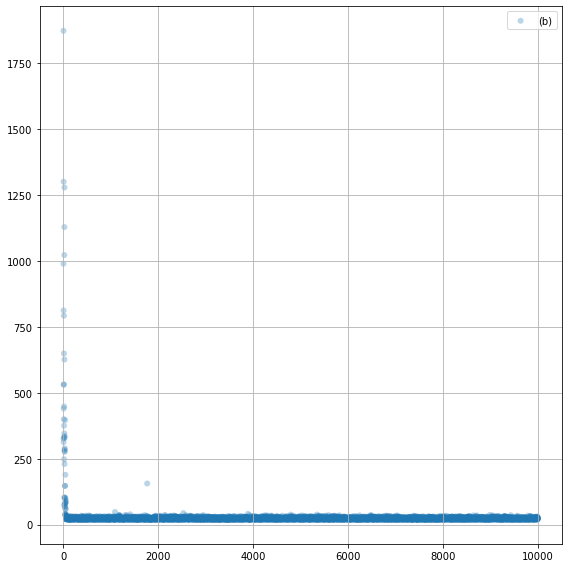

In [82]:
fig, ax = plt.subplots()
n = range(0,10000)
ax.scatter(n, state_sum4, c=['tab:blue'], label='(b)',
               alpha=0.3, edgecolors='none')\
#plt.ylim(0,2000)
ax.legend()
ax.grid(True)
fig.set_size_inches(8,8)
plt.show()

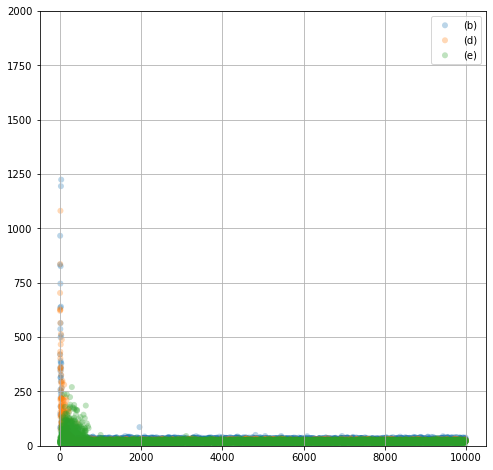

In [16]:
fig, ax = plt.subplots()
n = range(0,10000)
ax.scatter(n, state_sum1, c=['tab:blue'], label='(b)',
               alpha=0.3, edgecolors='none')
ax.scatter(n, state_sum2, c=['tab:orange'], label='(d)',
               alpha=0.3, edgecolors='none')
ax.scatter(n, state_sum3, c=['tab:green'], label='(e)',
               alpha=0.3, edgecolors='none')
fig.set_size_inches(8,8)
plt.ylim(0,2000)
ax.legend()
ax.grid(True)
plt.show()

## Get Shortest Paths
Now that the AI agent has been fully trained, we can see what it has learned by displaying the shortest path between any location in the warehouse where the robot is allowed to travel and the item packaging area.

![warehouse map](https://www.danielsoper.com/teaching/img/08-warehouse-map.png)

Run the code cell below to try a few different starting locations!

In [17]:
shortest_path = get_shortest_path(0, 0,q_values1)
for i in tqdm(range(1000)):
    
    path = get_shortest_path(0, 0,q_values1)
    if (len(path)<len(shortest_path)):
        shortest_path = path
len(shortest_path)
path1 = np.array(shortest_path)


100%|██████████| 1000/1000 [00:01<00:00, 686.71it/s]


In [18]:
#print(get_shortest_path(0, 0,q_values2))


In [19]:

shortest_path = get_shortest_path(0, 0,q_values3)
for i in tqdm(range(1000)):
    
    path = get_shortest_path(0, 0,q_values3)
    if (len(path)<len(shortest_path)):
        shortest_path = path
len(shortest_path)
path3 = np.array(shortest_path)

100%|██████████| 1000/1000 [00:01<00:00, 842.44it/s]


In [50]:

shortest_path = get_shortest_path(0, 0,q_values2)
for i in tqdm(range(1000)):
    
    path = get_shortest_path(0, 0,q_values2)
    if (len(path)<len(shortest_path)):
        shortest_path = path
len(shortest_path)
path2 = np.array(shortest_path)

100%|██████████| 1000/1000 [00:01<00:00, 843.01it/s]


In [79]:
shortest_path = get_shortest_path(0, 0,q_values4)
for i in tqdm(range(1000)):
    
    path = get_shortest_path(0, 0,q_values4)
    if (len(path)<len(shortest_path)):
        shortest_path = path
len(shortest_path)
path4 = np.array(shortest_path)

100%|██████████| 1000/1000 [00:01<00:00, 788.54it/s]


In [22]:
for move in shortest_path:
    print(move)
print(type(path))

[0, 0]
[0, 0]
[0, 0]
[0, 1]
[0, 1]
[0, 1]
[0, 0]
[0, 1]
[1, 1]
[1, 1]
[1, 0]
[1, 1]
[1, 0]
[0, 0]
[1, 0]
[1, 0]
[0, 0]
[1, 0]
[2, 0]
[3, 0]
[4, 0]
[4, 0]
[3, 0]
[3, 1]
[3, 0]
[4, 0]
[5, 0]
[5, 1]
[5, 2]
[5, 1]
[5, 2]
[5, 3]
[5, 4]
[5, 5]
[5, 6]
[5, 6]
[5, 5]
[6, 5]
[6, 6]
[5, 6]
[6, 6]
[6, 7]
[6, 6]
[6, 5]
[7, 5]
[7, 6]
[7, 7]
[8, 7]
[9, 7]
[10, 7]
[11, 7]
[11, 6]
[11, 5]
<class 'list'>


#### Finally...
It's great that our robot can automatically take the shortest path from any 'legal' location in the warehouse to the item packaging area. **But what about the opposite scenario?**

Put differently, our robot can currently deliver an item from anywhere in the warehouse ***to*** the packaging area, but after it delivers the item, it will need to travel ***from*** the packaging area to another location in the warehouse to pick up the next item!

Don't worry -- this problem is easily solved simply by ***reversing the order of the shortest path***.

Run the code cell below to see an example:

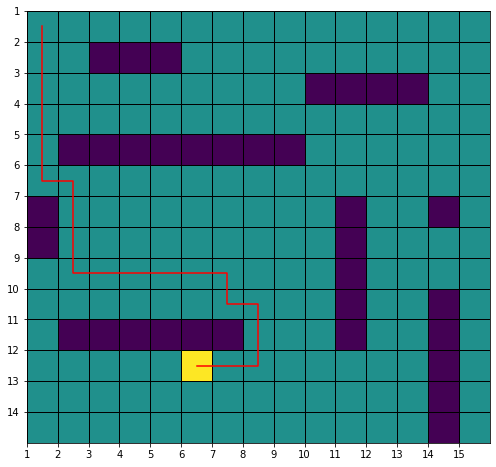

In [80]:
plt.rcParams["figure.figsize"] = [7.00, 7]
plt.rcParams["figure.autolayout"] = True
plt.imshow(rewards,interpolation='nearest')
ax = plt.gca()
ax.set_xticks(np.arange(-.5, 14, 1))
ax.set_yticks(np.arange(-.5, 13, 1))
ax.set_xticklabels(np.arange(1, 16, 1))
ax.set_yticklabels(np.arange(1, 15, 1))
ax.grid(color='black', linestyle='-', linewidth=1)
plt.plot(path4[:, 1], path4[:, 0],color = 'red')
plt.show()

In [24]:
test = q_values4[0,0]
print(test)
action_index = get_next_action(0,0,eps=1, q=q_values4)

print("action index method :",action_index)

if np.random.rand()<1:
    action_index_candidates = np.argwhere(q_values4[0, 0] == np.max(q_values4[0, 0]))
    print(action_index_candidates)
    chosen_action_index = np.random.choice(action_index_candidates.flatten(), size=1)[0]
    print("by hand :",chosen_action_index)
else:
    print("chose: ",np.random.randint(2,size=10))

[0. 0. 0. 0.]
action index method : 1
[[0]
 [1]
 [2]
 [3]]
by hand : 1


In [25]:
np.max(test)

0.0

In [26]:
def state_action_pairs(q,path):
    print("State = y x chosen action \t up \t\t\t right \t\t\t left \t\t\t down")
    for move in path:
        
        y=move[0]
        x=move[1]
        q_here = q[y,x]
        action = get_next_action(y,x,1,q)
        print("State =",(y+1),(x+1),"\t",actions[action],
              "\t",q_here[0],
              "\t",q_here[1],
              "\t",q_here[2],
              "\t",q_here[3])

In [81]:
state_action_pairs(q_values4,path4)

State = y x chosen action 	 up 			 right 			 left 			 down
State = 1 1 	 down 	 0.300943121160857 	 0.2738341326602314 	 0.3169070870813406 	 0.3028593999908211
State = 2 1 	 down 	 0.30196595150705124 	 0.2850096668271076 	 0.33212324685063255 	 0.3183689922259162
State = 3 1 	 down 	 0.32289027949777055 	 0.32083874816964914 	 0.3536388538757895 	 0.3391984068128693
State = 4 1 	 down 	 0.33806028804547106 	 0.32332235242106294 	 0.37715412815913923 	 0.36092824503645765
State = 5 1 	 down 	 0.3594483000687254 	 0.3827952932331571 	 0.40227572242938636 	 0.37848978415583645
State = 6 1 	 right 	 0.37908969121235386 	 0.4288272271832142 	 0.4050575608395164 	 0.40779480147549946
State = 6 2 	 down 	 0.42971415885862285 	 0.4014719195463293 	 0.4535121894706112 	 0.4092844660626463
State = 7 2 	 down 	 0.4298501856925059 	 0.4496884518372176 	 0.48060423824325127 	 0.4572659490027843
State = 8 2 	 down 	 0.45138622470801865 	 0.48981012918844175 	 0.504656742076751 	 0.4768199677784615

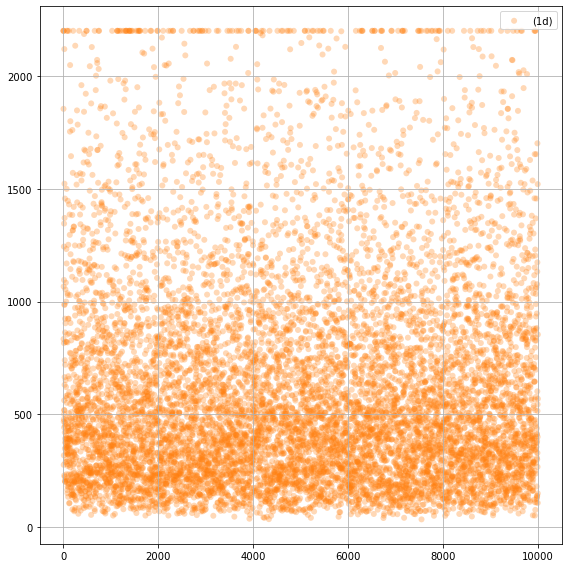

In [66]:
fig, ax = plt.subplots()
n = range(0,10000)
#ax.scatter(n, state_sum1, c=['tab:blue'], label='(1b)',
#               alpha=0.3, edgecolors='none')
ax.scatter(n, state_sum4, c=['tab:orange'], label='(1d)',
               alpha=0.3, edgecolors='none')
ax.legend()
ax.grid(True)
fig.set_size_inches(8,8)
plt.show()